# Use case: Monitoring particulate matter in highly polluted areas in Europe

### User Question: Can  satellite data capture the aerosol seasonal variability in the most polluted areas of Europe?

Despite improvements, air pollution is still a major health concern for Europeans. In 2019, air pollution continued to drive a significant burden of premature death and disease in Europe. In central and eastern Europe, the burning of solid fuels for domestic heating and their use in industry results in the highest concentrations of particulate matter. Although the trend of aerosol optical depth (AOD) over Europe has been well investigated, few studies have focused on fine-mode AOD (fAOD), which is more strongly associated with anthropogenic activities. Understanding changes in fAOD is an important step toward developing measures to mitigate air pollution and global climate change. In 2019, 97% of the urban population was exposed to concentrations of fine particulate matter (PM2.5) above the new WHO guideline level of 5 µg/m3. Eastern Europe was one of the regions with the highest concentrations of PM2.5. Hence, it is important to study the aerosol seasonal variability in the Eastern Europe. This notebook concludes that the aerosol dataset is able to monitor the most polluted areas of Europe. 

### Quality assessment statement

The AOD and fine-mode AOD from the SLSTR sensor on the Sentinel 3 satellite can capture the aerosol seasonal variability.

### Methodology

The analysis comprises the following steps: 

• Download AOD and fAOD data (AOD550 and FM_AOD550 (Aerosol properties gridded data from 1995 to present derived from satellite observations), orizontal resolution: 1° x 1°; temporal resolution: monthly);

• Compute the spatially weighted mean time series for AOD and fAOD;

• Create the spatial maps of AOD550 and FM_AOD550 over east Europe for 2019;

• Calculate and plot the seasonal mean of AOD and fAOD over eastern Europe for the years 2019 and 2020.

• Calculate and plot the seasonal mean of AOD and fAOD over the east and west of Europe for the year 2019.

### Analysis and Results
### Import packages

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import pandas as pd
from c3s_eqc_automatic_quality_control import diagnostics, download, plot,utils
import warnings
warnings.filterwarnings("ignore")

### Define request

In [2]:
collection_id = "satellite-aerosol-properties"

year_start = 2019
year_stop = 2019

#east Europe
lon_slice = slice(7.5, 24.4)
lat_slice = slice(43.7, 54.3)

request = {
    "format": "zip",
    "time_aggregation": "monthly_average",
    "variable": "aerosol_optical_depth",
    "sensor_on_satellite": "slstr_on_sentinel_3a",
    "algorithm": "ens",
    "year": [str(year) for year in range(year_start, year_stop + 1)],
    "month": [f"{month:02d}" for month in range(1, 12 + 1)],
    "version": "v2.1",
}

### Transform and download data

In [3]:
ds = download.download_and_transform(
    collection_id,
    request,
    split_all=True
)

100%|██████████| 12/12 [00:05<00:00,  2.10it/s]


### Convert and redefine the time dimension of monthly data for 2019

In [4]:
ds_monthly = ds
ds_monthly["source"] = ds_monthly["source"].str.slice(None, 6)
ds_monthly["source"] = pd.to_datetime(ds_monthly["source"],format="%Y%m")
ds_monthly = ds_monthly.rename({'source': 'time'})
ds_monthly = utils.regionalise(ds_monthly, lon_slice=lon_slice, lat_slice=lat_slice)
#print(ds_monthly)

### Calculate the seasonal averages 

In [25]:
ds_seas=ds_monthly.groupby('time.season').mean() #seasonal mean


### Define functions to calculate the seasonal mean of AOD and fAOD for the determined period.

In [6]:
def source_to_time_seasonal(ds):
    ds_time = pd.to_datetime(ds["source"].str.slice(None, 6), format="%Y%m").to_period("Q")
    ds = ds.rename({"source": "time"})
    ds["time"] = ds_time.astype(str)  # Convert to string format
    return ds
    
def source_to_time_seasonal_and_spatial_weighted_mean(ds, lon_slice, lat_slice):
    ds = utils.regionalise(ds, lon_slice=lon_slice, lat_slice=lat_slice)
    return diagnostics.spatial_weighted_mean(source_to_time_seasonal(ds))



### Download the seasonal and spatial weighted mean AOD and fAOD 

In [8]:
ds_mean = download.download_and_transform(
    collection_id,
    request,
    transform_func=source_to_time_seasonal_and_spatial_weighted_mean,
    transform_func_kwargs={
        "lon_slice": lon_slice,
        "lat_slice": lat_slice,
    },
    split_all=True
)

print(ds_mean)

100%|██████████| 12/12 [00:00<00:00, 12.56it/s]


<xarray.Dataset> Size: 160B
Dimensions:                      (time: 4)
Coordinates:
  * time                         (time) <U6 96B '2019Q1' '2019Q2' ... '2019Q4'
Data variables:
    AOD550                       (time) float32 16B dask.array<chunksize=(1,), meta=np.ndarray>
    FM_AOD550                    (time) float32 16B dask.array<chunksize=(1,), meta=np.ndarray>
    AOD550_UNCERTAINTY_ENSEMBLE  (time) float32 16B dask.array<chunksize=(1,), meta=np.ndarray>
    NMEAS                        (time) float32 16B dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/18)
    Conventions:               CF-1.6
    creator_email:             thomas.popp@dlr.de
    creator_name:              German Aerospace Center, DFD
    geospatial_lat_max:        90.0
    geospatial_lat_min:        -90.0
    geospatial_lon_max:        180.0
    ...                        ...
    sensor:                    SLSTR
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    su

### Setting up data for AOD and fAOD and downloading the monthly average dataset over east Europe for 2020 from two versions, V2.1 and V2.2

In [9]:
from c3s_eqc_automatic_quality_control import download

collection_id = "satellite-aerosol-properties"
request2020 = {
    "format": "zip",
    "time_aggregation": "monthly_average",
    "variable": "aerosol_optical_depth",
    "sensor_on_satellite": "slstr_on_sentinel_3a",
    "algorithm": "ens",
}

time_dict = {
    "v2.1": {"start": "2020-01", "stop": "2020-06"},
    "v2.2": {"start": "2020-07", "stop": "2020-12"},
}

lon_slice = slice(7.5, 24.4)
lat_slice = slice(43.7, 54.3)

ds_dict = {}
for version, kwargs in time_dict.items():
    requests = download.update_request_date(
        request2020 | {"version": version}, **kwargs, stringify_dates=True
    )
    ds_dict[version] = download.download_and_transform(
        collection_id, requests, chunks={"year": 1, "month": 1}
    )

print(ds_dict)


100%|██████████| 6/6 [00:00<00:00, 11.13it/s]


{'v2.1': <xarray.Dataset> Size: 6MB
Dimensions:                      (source: 6, latitude: 180, longitude: 360)
Coordinates:
  * source                       (source) object 48B '202001-C3S-L3_AEROSOL-A...
  * latitude                     (latitude) float32 720B -89.5 -88.5 ... 89.5
  * longitude                    (longitude) float32 1kB -179.5 -178.5 ... 179.5
Data variables:
    AOD550                       (source, latitude, longitude) float32 2MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    FM_AOD550                    (source, latitude, longitude) float32 2MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    AOD550_UNCERTAINTY_ENSEMBLE  (source, latitude, longitude) float32 2MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    NMEAS                        (source, latitude, longitude) float32 2MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes: (12/18)
    Conventions:               CF-1.6
    creator_email:             thomas.popp@dlr.de

### Convert and redefine the time dimension of monthly data for 2020

In [10]:
ds_monthly_dict = {}
for version, ds in ds_dict.items():
    ds_monthly = ds.copy()
    ds_monthly["source"] = ds_monthly["source"].str.slice(None, 6)
    ds_monthly["source"] = pd.to_datetime(ds_monthly["source"], format="%Y%m")

    ds_monthly = ds_monthly.rename({'source': 'time'})

    ds_monthly = utils.regionalise(ds_monthly, lon_slice=lon_slice, lat_slice=lat_slice)

    ds_monthly_dict[version] = ds_monthly

for version, ds_monthly in ds_monthly_dict.items():
    print(f"Version {version}:")
    print(ds_monthly)


Version v2.1:
<xarray.Dataset> Size: 16kB
Dimensions:                      (time: 6, latitude: 10, longitude: 17)
Coordinates:
  * time                         (time) datetime64[ns] 48B 2020-01-01 ... 202...
  * latitude                     (latitude) float32 40B 44.5 45.5 ... 52.5 53.5
  * longitude                    (longitude) float32 68B 7.5 8.5 ... 22.5 23.5
Data variables:
    AOD550                       (time, latitude, longitude) float32 4kB dask.array<chunksize=(1, 10, 17), meta=np.ndarray>
    FM_AOD550                    (time, latitude, longitude) float32 4kB dask.array<chunksize=(1, 10, 17), meta=np.ndarray>
    AOD550_UNCERTAINTY_ENSEMBLE  (time, latitude, longitude) float32 4kB dask.array<chunksize=(1, 10, 17), meta=np.ndarray>
    NMEAS                        (time, latitude, longitude) float32 4kB dask.array<chunksize=(1, 10, 17), meta=np.ndarray>
Attributes: (12/18)
    Conventions:               CF-1.6
    creator_email:             thomas.popp@dlr.de
    creator_n

### Combine the two monthly datasets along the version dimension

In [11]:
ds_monthly_merged = xr.concat([ds_monthly_dict['v2.1'],ds_monthly_dict['v2.2']], dim='time')

print(ds_monthly_merged)

<xarray.Dataset> Size: 33kB
Dimensions:                      (time: 12, latitude: 10, longitude: 17)
Coordinates:
  * time                         (time) datetime64[ns] 96B 2020-01-01 ... 202...
  * latitude                     (latitude) float32 40B 44.5 45.5 ... 52.5 53.5
  * longitude                    (longitude) float32 68B 7.5 8.5 ... 22.5 23.5
Data variables:
    AOD550                       (time, latitude, longitude) float32 8kB dask.array<chunksize=(1, 10, 17), meta=np.ndarray>
    FM_AOD550                    (time, latitude, longitude) float32 8kB dask.array<chunksize=(1, 10, 17), meta=np.ndarray>
    AOD550_UNCERTAINTY_ENSEMBLE  (time, latitude, longitude) float32 8kB dask.array<chunksize=(1, 10, 17), meta=np.ndarray>
    NMEAS                        (time, latitude, longitude) float32 8kB dask.array<chunksize=(1, 10, 17), meta=np.ndarray>
Attributes: (12/18)
    Conventions:               CF-1.6
    creator_email:             thomas.popp@dlr.de
    creator_name:         

### Calculate the dataset average values in each season during 2020 and merge the two versions.

In [12]:
ds_seas_mereged = ds_monthly_merged.groupby('time.season').mean()
print(ds_seas_mereged)

<xarray.Dataset> Size: 11kB
Dimensions:                      (season: 4, latitude: 10, longitude: 17)
Coordinates:
  * latitude                     (latitude) float32 40B 44.5 45.5 ... 52.5 53.5
  * longitude                    (longitude) float32 68B 7.5 8.5 ... 22.5 23.5
  * season                       (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    AOD550                       (season, latitude, longitude) float32 3kB dask.array<chunksize=(1, 10, 17), meta=np.ndarray>
    FM_AOD550                    (season, latitude, longitude) float32 3kB dask.array<chunksize=(1, 10, 17), meta=np.ndarray>
    AOD550_UNCERTAINTY_ENSEMBLE  (season, latitude, longitude) float32 3kB dask.array<chunksize=(1, 10, 17), meta=np.ndarray>
    NMEAS                        (season, latitude, longitude) float32 3kB dask.array<chunksize=(1, 10, 17), meta=np.ndarray>
Attributes: (12/18)
    Conventions:               CF-1.6
    creator_email:             thomas.popp@dlr.de
    creator_name:    

## Visualize the results

### Seasonal mean maps of AOD over eastern Europe for the years 2019 and 2020.

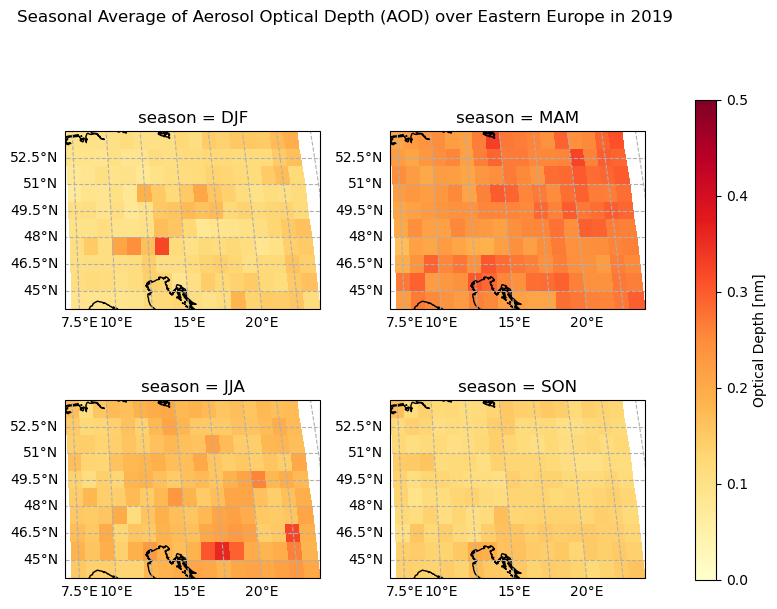

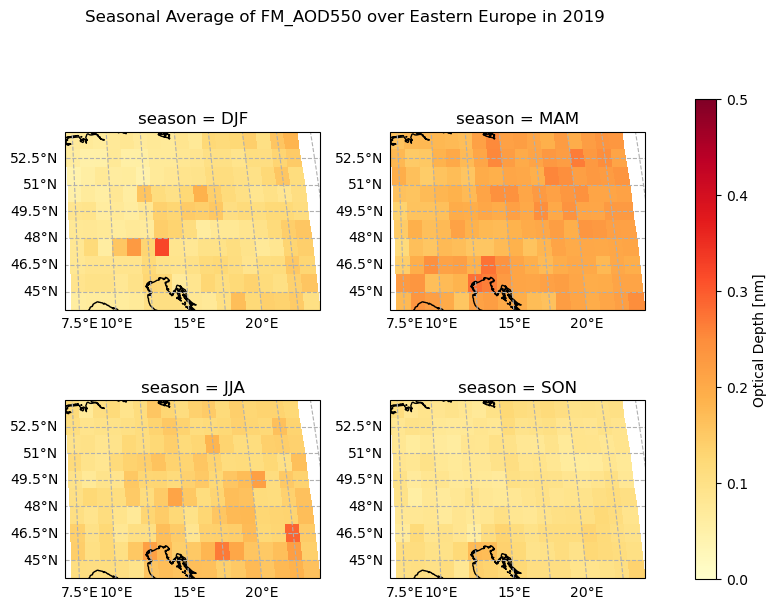

In [24]:
titles = ['season = DJF', 'season = MAM', 'season = JJA', 'season = SON']

map_proj = ccrs.Robinson()

p = ds_seas["AOD550"].plot.pcolormesh(cmap='YlOrRd', vmax=0.5, vmin=0, col="season", col_wrap=2,
                                      transform=ccrs.PlateCarree(),
                                      subplot_kws={"projection": map_proj},
                                      add_colorbar=False)

for ax, title in zip(p.axs.flat, titles):
    ax.coastlines()
    ax.set_title(title)
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

mappable = p.axes[0][0].collections[0]

# Create colorbar
cax = plt.axes([1, 0.1, 0.03, 0.8])
cbar = plt.colorbar(mappable, cax=cax)
cbar.set_label('Optical Depth [nm]')

# Set the main title for the entire figure
plt.suptitle("Seasonal Average of Aerosol Optical Depth (AOD) over Eastern Europe in 2019", y=1.05)

plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust layout to make space for the main title
plt.show()
########

map_proj = ccrs.Robinson()

p = ds_seas["FM_AOD550"].plot.pcolormesh(cmap='YlOrRd', vmax=0.5, vmin=0, col="season", col_wrap=2,
                                      transform=ccrs.PlateCarree(),
                                      subplot_kws={"projection": map_proj},
                                      add_colorbar=False)

for ax, title in zip(p.axs.flat, titles):
    ax.coastlines()
    ax.set_title(title)
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

mappable = p.axes[0][0].collections[0]

# Create colorbar
cax = plt.axes([1, 0.1, 0.03, 0.8])
cbar = plt.colorbar(mappable, cax=cax)
cbar.set_label('Optical Depth [nm]')

# Set the main title for the entire figure
plt.suptitle("Seasonal Average of FM_AOD550 over Eastern Europe in 2019", y=1.05)

plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust layout to make space for the main title
plt.show()


### Setting up data for AOD and fAOD and download the seasonal average dataset over east Europe for 2020

In [25]:
from c3s_eqc_automatic_quality_control import download

collection_id = "satellite-aerosol-properties"
request2020 = {
    "format": "zip",
    "time_aggregation": "monthly_average",
    "variable": "aerosol_optical_depth",
    "sensor_on_satellite": "slstr_on_sentinel_3a",
    "algorithm": "ens",
}

time_dict = {
    "v2.1": {"start": "2020-01", "stop": "2020-06"},
    "v2.2": {"start": "2020-07", "stop": "2020-12"},
}
lon_slice = slice(7.5, 24.4)
lat_slice = slice(43.7, 54.3)


ds_dict = {}

def custom_transform_func(ds):
    return source_to_time_seasonal_and_spatial_weighted_mean(ds, lon_slice, lat_slice)

for version, kwargs in time_dict.items():
    requests = download.update_request_date(
        request2020 | {"version": version}, **kwargs, stringify_dates=True
    )
    
    # Use the download_and_transform function if available
    ds_chunked = download.download_and_transform(
        collection_id, requests, chunks={"year": 1, "month": 1},
        transform_func=custom_transform_func
    )

    # Cache or use the transformed dataset as needed
    ds_dict[version] = ds_chunked

# Merge the transformed datasets
final_dataset = xr.merge(list(ds_dict.values()))
print(final_dataset)



100%|██████████| 6/6 [00:00<00:00, 19.15it/s]


<xarray.Dataset> Size: 160B
Dimensions:                      (time: 4)
Coordinates:
  * time                         (time) <U6 96B '2020Q1' '2020Q2' ... '2020Q4'
Data variables:
    AOD550                       (time) float32 16B dask.array<chunksize=(3,), meta=np.ndarray>
    FM_AOD550                    (time) float32 16B dask.array<chunksize=(3,), meta=np.ndarray>
    AOD550_UNCERTAINTY_ENSEMBLE  (time) float32 16B dask.array<chunksize=(3,), meta=np.ndarray>
    NMEAS                        (time) float32 16B dask.array<chunksize=(3,), meta=np.ndarray>
Attributes: (12/18)
    Conventions:               CF-1.6
    creator_email:             thomas.popp@dlr.de
    creator_name:              German Aerospace Center, DFD
    geospatial_lat_max:        90.0
    geospatial_lat_min:        -90.0
    geospatial_lon_max:        180.0
    ...                        ...
    sensor:                    SLSTR
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    su

### Seasonal line plots of AOD over east Europe in 2019 and 2020

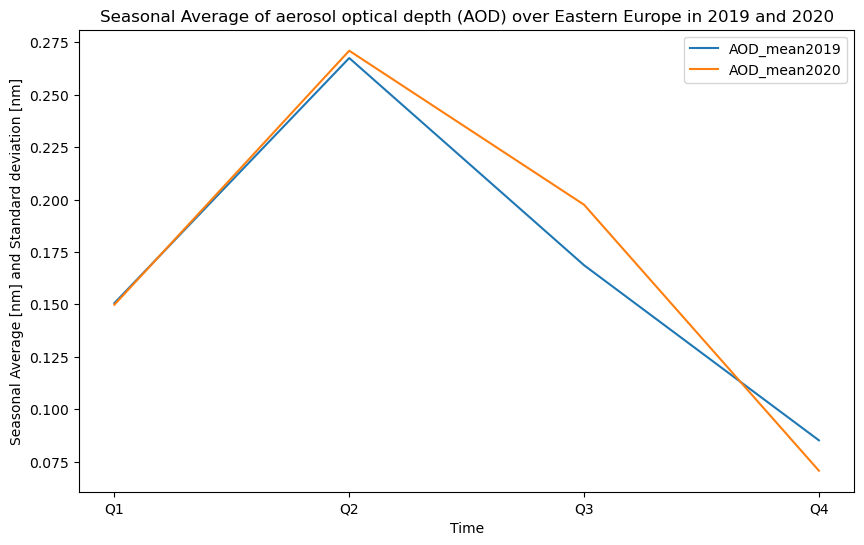

In [26]:
import matplotlib.pyplot as plt
import numpy as np
t = ds_mean["time"] 
# Assuming 't' contains the time values in the format 'YYYYQn'
# Extract the quarters from the coordinates
quarters = np.unique([time[-2:] for time in t.coords['time'].values.astype(str)])

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

y1 = ds_mean['AOD550']
plt.plot(t, y1, label="AOD_mean2019")

y2 = final_dataset['AOD550']
plt.plot(t, y2, label="AOD_mean2020")

ax.set_xlabel('Time')
ax.set_ylabel('Seasonal Average [nm] and Standard deviation [nm]')
ax.set_title('Seasonal Average of aerosol optical depth (AOD) over Eastern Europe in 2019 and 2020')
ax.legend()

# Set custom x-axis ticks
plt.xticks(t.values, quarters)
plt.show()


### Seasonal line plots of fAOD over east Europe in 2019 and 2020

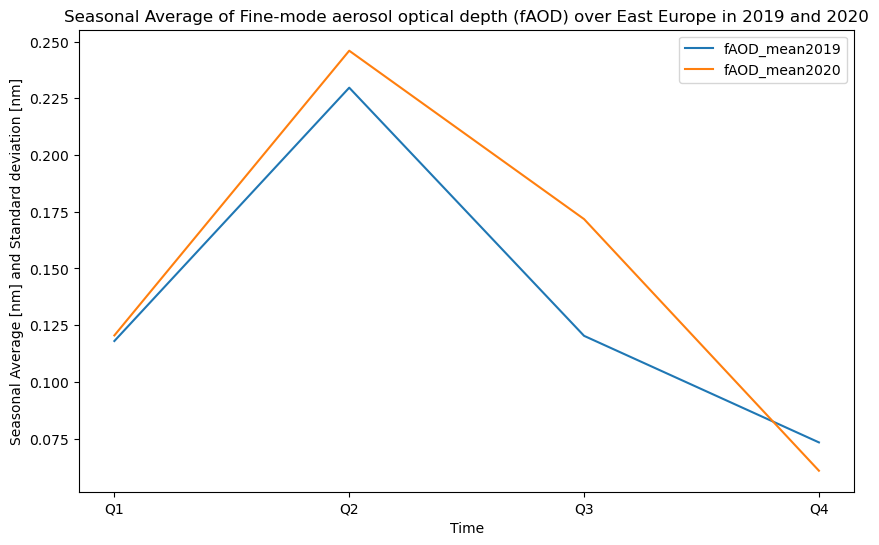

In [27]:
import matplotlib.pyplot as plt
import numpy as np
t = ds_mean["time"] 
# Assuming 't' contains the time values in the format 'YYYYQn'
# Extract the quarters from the coordinates
quarters = np.unique([time[-2:] for time in t.coords['time'].values.astype(str)])

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

y1 = ds_mean['FM_AOD550']
plt.plot(t, y1, label="fAOD_mean2019")

y2 = final_dataset['FM_AOD550']
plt.plot(t, y2, label="fAOD_mean2020")

ax.set_xlabel('Time')
ax.set_ylabel('Seasonal Average [nm] and Standard deviation [nm]')
ax.set_title('Seasonal Average of Fine-mode aerosol optical depth (fAOD) over East Europe in 2019 and 2020')
ax.legend()

# Set custom x-axis ticks
plt.xticks(t.values, quarters)

plt.show()


### Define the request for western Europe in 2019

In [28]:
#Define request
collection_id = "satellite-aerosol-properties"

year_start = 2019
year_stop = 2019

#west Europe
lon_slice = slice(-2.4, 3.5)
lat_slice = slice(44, 49.4)
requestwest = {
    "format": "zip",
    "time_aggregation": "monthly_average",
    "variable": "aerosol_optical_depth",
    "sensor_on_satellite": "slstr_on_sentinel_3a",
    "algorithm": "ens",
    "year": [str(year) for year in range(year_start, year_stop + 1)],
    "month": [f"{month:02d}" for month in range(1, 12 + 1)],
    "version": "v2.1",
}

### Download AOD and fAOD data for western Europe in 2019

In [29]:
dswest = download.download_and_transform(
    collection_id,
    requestwest,
    split_all=True
)

100%|██████████| 12/12 [00:01<00:00,  8.08it/s]


### Convert and redefine the time dimension of monthly data for 2019

In [30]:
dswest_monthly = dswest
dswest_monthly["source"] = dswest_monthly["source"].str.slice(None, 6)
dswest_monthly["source"] = pd.to_datetime(dswest_monthly["source"],format="%Y%m")
dswest_monthly = dswest_monthly.rename({'source': 'time'})
dswest_monthly = utils.regionalise(dswest_monthly, lon_slice=lon_slice, lat_slice=lat_slice)
#print(ds_monthly)

### Calculate the dataset average values in each season during 2019 over west Europe 

In [31]:
dswest_seas=dswest_monthly.groupby('time.season').mean() #seasonal mean
print(dswest_seas)

<xarray.Dataset> Size: 2kB
Dimensions:                      (season: 4, latitude: 5, longitude: 6)
Coordinates:
  * latitude                     (latitude) float32 20B 44.5 45.5 46.5 47.5 48.5
  * longitude                    (longitude) float32 24B -1.5 -0.5 ... 2.5 3.5
  * season                       (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    AOD550                       (season, latitude, longitude) float32 480B dask.array<chunksize=(1, 5, 6), meta=np.ndarray>
    FM_AOD550                    (season, latitude, longitude) float32 480B dask.array<chunksize=(1, 5, 6), meta=np.ndarray>
    AOD550_UNCERTAINTY_ENSEMBLE  (season, latitude, longitude) float32 480B dask.array<chunksize=(1, 5, 6), meta=np.ndarray>
    NMEAS                        (season, latitude, longitude) float32 480B dask.array<chunksize=(1, 5, 6), meta=np.ndarray>
Attributes: (12/18)
    Conventions:               CF-1.6
    creator_email:             thomas.popp@dlr.de
    creator_name:          

### Download seasonal and spatial weighted mean of AOD and fAOD data over wetern Europe

In [32]:
dswest_mean = download.download_and_transform(
    collection_id,
    requestwest,
    transform_func=source_to_time_seasonal_and_spatial_weighted_mean,
    transform_func_kwargs={
        "lon_slice": lon_slice,
        "lat_slice": lat_slice,
    },
    split_all=True
)

print(dswest_mean)

100%|██████████| 12/12 [00:00<00:00, 13.19it/s]


<xarray.Dataset> Size: 160B
Dimensions:                      (time: 4)
Coordinates:
  * time                         (time) <U6 96B '2019Q1' '2019Q2' ... '2019Q4'
Data variables:
    AOD550                       (time) float32 16B dask.array<chunksize=(1,), meta=np.ndarray>
    FM_AOD550                    (time) float32 16B dask.array<chunksize=(1,), meta=np.ndarray>
    AOD550_UNCERTAINTY_ENSEMBLE  (time) float32 16B dask.array<chunksize=(1,), meta=np.ndarray>
    NMEAS                        (time) float32 16B dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/18)
    Conventions:               CF-1.6
    creator_email:             thomas.popp@dlr.de
    creator_name:              German Aerospace Center, DFD
    geospatial_lat_max:        90.0
    geospatial_lat_min:        -90.0
    geospatial_lon_max:        180.0
    ...                        ...
    sensor:                    SLSTR
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    su

### The line plots of AOD550 over east and west of Europe in 2019

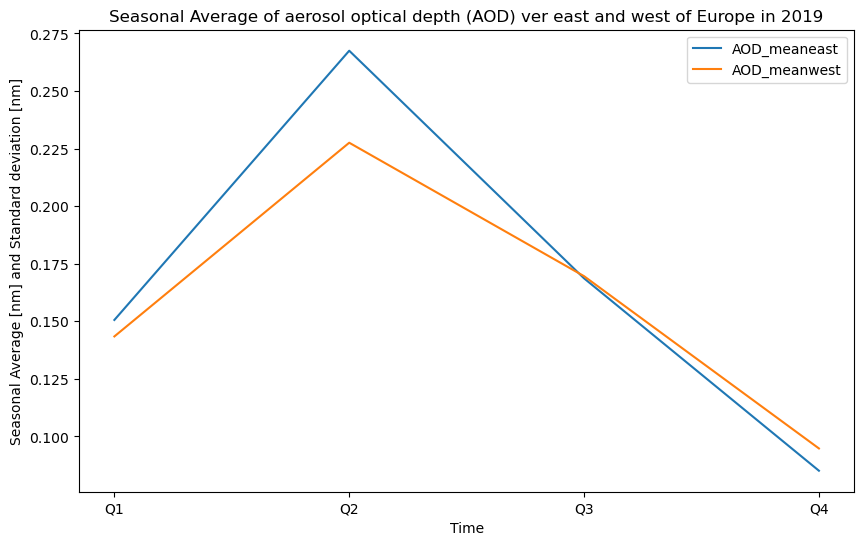

In [33]:
import matplotlib.pyplot as plt
import numpy as np
t = dswest_mean["time"] 


# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

y1 = ds_mean['AOD550']
plt.plot(t, y1, label="AOD_meaneast")

y2 = dswest_mean['AOD550']
plt.plot(t, y2, label="AOD_meanwest")

ax.set_xlabel('Time')
ax.set_ylabel('Seasonal Average [nm] and Standard deviation [nm]')
ax.set_title('Seasonal Average of aerosol optical depth (AOD) ver east and west of Europe in 2019')
ax.legend()

# Set custom x-axis ticks
plt.xticks(t.values, quarters)

plt.show()

### The line plots of FM_AOD550 over east and west of Europe in 2019

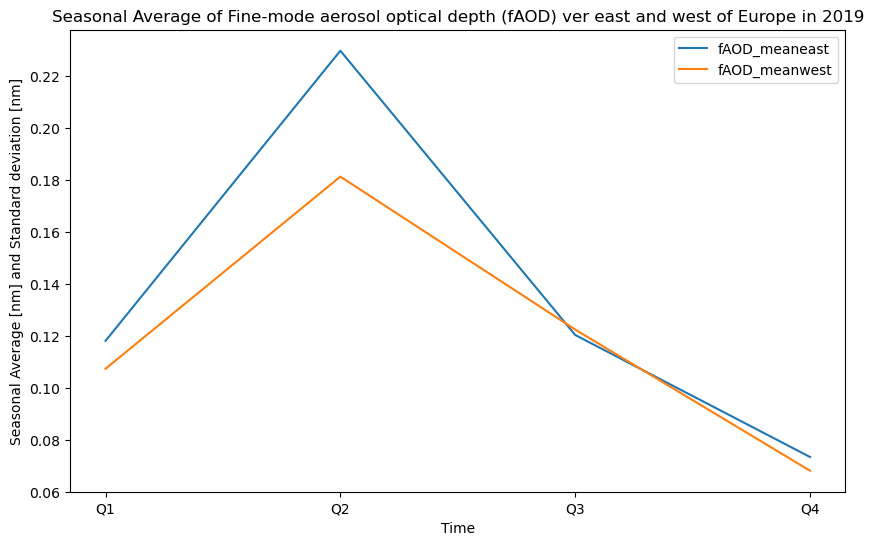

In [34]:
import matplotlib.pyplot as plt
import numpy as np
t = dswest_mean["time"] 


# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

y1 = ds_mean['FM_AOD550']
plt.plot(t, y1, label="fAOD_meaneast")

y2 = dswest_mean['FM_AOD550']
plt.plot(t, y2, label="fAOD_meanwest")

ax.set_xlabel('Time')
ax.set_ylabel('Seasonal Average [nm] and Standard deviation [nm]')
ax.set_title('Seasonal Average of Fine-mode aerosol optical depth (fAOD) ver east and west of Europe in 2019')
ax.legend()

# Set custom x-axis ticks
plt.xticks(t.values, quarters)

plt.show()

### Main outcome
1. The air pollution was compared for the years 2019 and 2020 by examining the seasonal temporal and spatial variations of the AOD using the AOD product from the SLSTR instrument on board Sentinel-3. AOD concentration in 2019, especially in the summer, is higher than in 2020, which is in accordance with PM10 concentrations reported over Europe within the European Environment Agency's (EEA) report on Europe's air quality status issue in 2021. The report states that PM10 levels increased in Eastern Europe in 2019. Therefore, it can be concluded that AOD and PM10 variability are generally correlated.
2. The comparison of AOD and fAOD seasonal averages in 2019 and 2020 over Eastern Europe reveals that the coarse aerosol fraction is dominant in winter and autumn, and this agrees with the increased PM10 concentration compared to PM2.5 over Eastern Europe, as shown in the same report from the EEA.
3. Seasonal averages of AOD and fAOD in 2019 over the east and west of Europe demonstrate that higher AOD and fAOD values are observed over the east compared to the west. 
Also, these results are in accordance with the EEA report, which states that PM2.5 and PM10 levels increased in eastern Europe in 2019.

### References

1. https://www.eea.europa.eu/publications/air-quality-in-europe-2021/air-quality-status-briefing-2021 Report no. 15/2021 Title: Air quality in Europe 2021 HTML - TH-AL-21-014-EN-Q - ISBN 978-92-9480-403-7 - ISSN 1977-8449 - doi: 10.2800/549289
2. Khomenko, S., Cirach, M., Pereira-Barboza, E., Mueller, N., Barrera-Gómez, J., Rojas-Rueda, D., de Hoogh, K., Hoek, G. and Nieuwenhuijsen, M., 2021. Premature mortality due to air pollution in European cities: a health impact assessment. The Lancet Planetary Health, 5(3), pp.e121-e134. (https://www.thelancet.com/journals/lanplh/article/PIIS2542-5196(20)30272-2/fulltext)
